# Documentation of Economic Analysis behind Simulation Engine - Part 3

In this notebook, we consider a dynamical system approach to analyze economic network response to demand shocks. Initially, an economy in a steady state is perturbed by means of an impulse shock. In a static view, where one assumes the output of economy will immediately adjust itself to the shock, will be contrasted with a dynamical system approach, especially in view of output behaviour with respect to time.

**Table of contents**
* [Dynamics of Shock response](#shock_dynamics)

**Inputs**
- L matrix from _Documentation of Economic Analysis behind Simulation Engine - Part 1_


In [1]:
# Imports and path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sbs

import random
from scipy.integrate import odeint

%matplotlib inline

<a id='shock_dynamics'></a>
## Static vs Dynamic shock response
A simple class definition of economic network with Leontief matrix with functions to produce impulse shock on country, sector and function to compute output given the demand.

In [21]:
class LeonTradeModel:
    
    def __init__(self,df_L,demand='unit'):
        self.df_L = df_L
        self.country_indices, self.sector_indices = df_L.index.get_level_values(0).values, df_L.index.get_level_values(1).values
        self.countries, self.sectors = df_L.index.get_level_values(0).unique().values, df_L.index.get_level_values(1).unique().values
        self.A = np.linalg.inv(self.df_L.values)
        if (demand == 'unit'):
            self.d_base = np.ones(len(df_L))
        else:
            self.d_base = demand
        self.x_base = np.dot(self.df_L.values,self.d_base)
        self.x_out = self.x_base
        
        
    def shock_impulse(self,shock_val,tsteps=30,country_code=None,sector_code=None):
        shock_vec = np.zeros(len(self.d_base))
        if (sector_code is not None) & (country_code is not None):
            #print(self.countries)
            #print(np.where(self.countries==country_code)[0])
            shocked_val_idx = (np.where(self.countries==country_code)[0][0] * len(set(self.sectors))) + np.where(self.sectors==sector_code)[0][0]
            
        elif (sector_code is None) & (country_code is not None):
            shocked_val_idx = np.where(self.country_indices==country_code)[0]
            
        elif (country_code is None) & (sector_code is not None):
            shocked_val_idx = np.where(self.sector_indices==sector_code)[0]
        
        shock_vec[shocked_val_idx] = shock_val
        
        return shock_vec
         
        
    def propagate_shock(self,shock_vec,inertia = 0,type='demand'):
        # Inertia models the time taken by the real economy to readjust.
        if type == 'demand':
            self.x_out = inertia*self.x_out + (1-inertia)*np.dot(self.df_L,demand_vec)
        else:
            self.x_out = inertia*self.x_out + (1-inertia)*np.dot(self.df_L.T,shock_vec)
            
        self.dem_out = demand_vec
        return self.x_out

Initialize a Economic network object with the actual Leontief matrix

In [22]:
# Read the L matrix and construct a dataframe with 2 indices country and sector
df_lev = pd.read_csv('< path >/Leontief_inverse_world.csv',low_memory=False,index_col=[0,1],skiprows=[0,1])
# Remap the column names
df_lev.columns = df_lev.index.get_level_values(1).values

network_model = LeonTradeModel(df_lev) 

Supply now a impulse shock at time=0 to say Sector 28 in Germany (DEU) and see the effect on same Sector 28 in the USA

In [23]:
shock_vec = network_model.shock_impulse(shock_val=0.01,country_code='DEU',sector_code='28')
demand_vec = shock_vec#network_model.d_base-shock_vec
x_out = network_model.propagate_shock(demand_vec)
out_change = x_out#(network_model.x_base-x_out)/network_model.x_base

print('Shock to Sector 28 in the US %s'%(out_change[1873]))
print('Overall output contraction %s'%(sum(out_change)))

Shock to Sector 28 in the US 2.2414136270656123e-06
Overall output contraction 0.01591377157759055


Visualize how the shock to Sector 28 in Germany affects other sectors in the same country

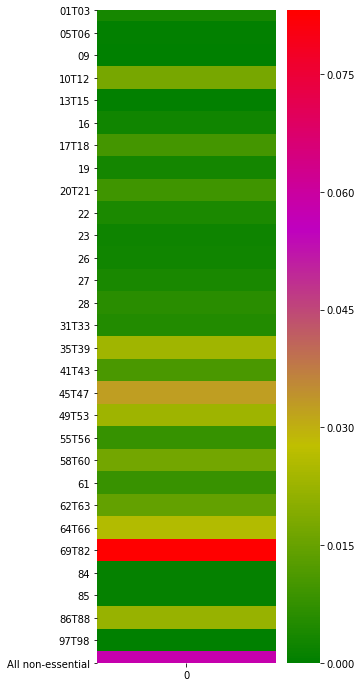

In [24]:
german_sector_indices = np.where(network_model.country_indices=='DEU')[0]

#german_sector_indices = german_sector_indices[german_sector_indices!=28]
response_shock_vals = (out_change[german_sector_indices])/max(shock_vec)
response_sector_mask = response_shock_vals<1


plt.figure(figsize=(4,12))

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('gymr',["g", "y","m", "r"], N=256) 

ax = sbs.heatmap((response_shock_vals[response_sector_mask]).reshape(-1,1),annot=False,ax=None,cmap=cmap)
ax.set_yticklabels(network_model.sectors[response_sector_mask],rotation=0);

Essentially, the number above says that an impulse 0.01 Demand shock to Sector 28 in Germany at time t=0 causes a shock of 2.2e-6 units in the same sector in the US at that instant and an overall contraction in the economic output of the world by 0.016 units 

Let us now make the shock response a bit more dynamic now. Following the work from Klimek et. al., (https://www.nature.com/articles/s41467-019-09357-w.pdf), we model the output dynamics by a simple ODE of order 1, 

$Y_{dot} = (A-I)* Y  + D$, 

where Y, Y_dot, A,I and D denote output, vector differential of the output, I/O matrix, Identity matrix of the corresponding shape and Demand vector respectively.

A useful technique now is to characterize the system response by perturbing the system by applying an impulse. Unlike mathematical impulses which have infinite height and zero width, in the scope of this analysis the impulse is modelled as a finite pulse of a certain height and duration.

For ease of analysis, it is assumed that the shock pulse starts at time 0 and ends at time step 1. Use standard numerical integration to solve for system response

In [25]:
def economic_dynamics_ode(y,t,A,D,step_width=1):
    if (t < step_width):
        d = D
    else:
        d = np.zeros(len(D))
    
    return np.dot(A-np.eye(A.shape[0]),y) + d

sol = odeint(economic_dynamics_ode, np.zeros(len(network_model.df_L)), np.linspace(0,10,10), args=(-network_model.A,shock_vec))

Let us now look at time evolution of sector 28 in the US.

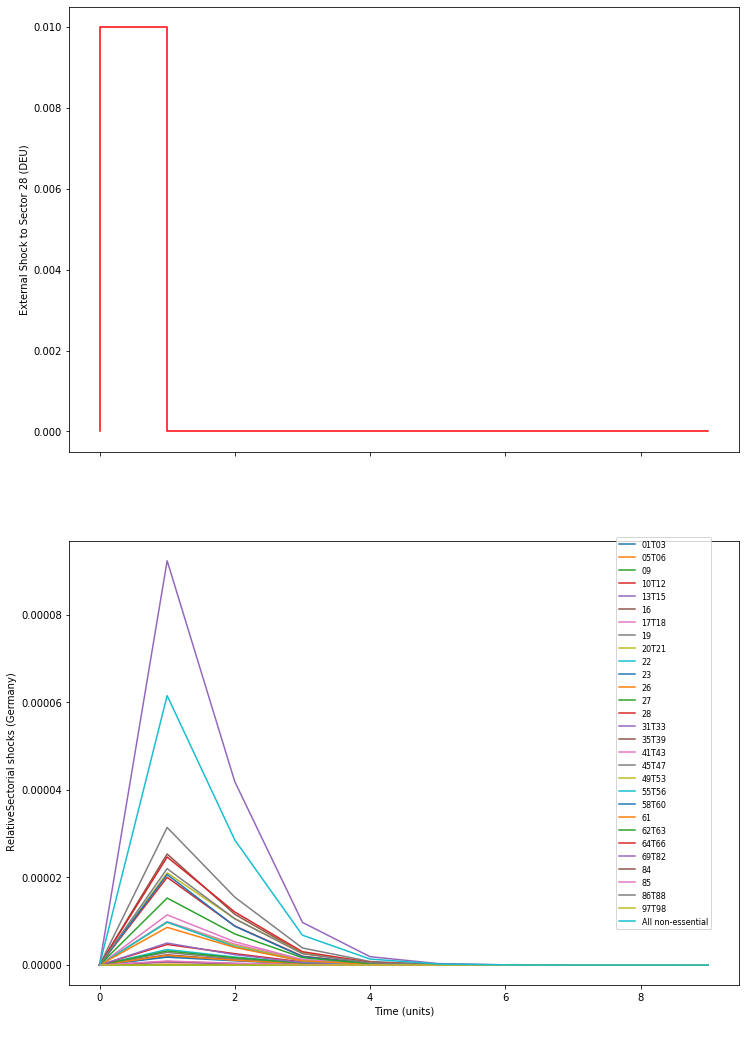

In [26]:
fig,axs=plt.subplots(2,1,figsize=(12,18),sharex=True)


axs[0].step(range(10),np.array([0,0.01,0,0,0,0,0,0,0,0]),'r')
axs[0].set_ylabel('External Shock to Sector 28 (DEU)');
axs[1].plot(range(10),sol[:,german_sector_indices[response_sector_mask]],'-');
axs[1].set_xlabel('Time (units)');
axs[1].set_ylabel(' RelativeSectorial shocks (Germany)');
leg = axs[1].legend(network_model.sectors[response_sector_mask],prop={'size':8},loc='upper right')
plt.draw()
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = -0.25
bb.x0 += xOffset
bb.x1 += xOffset - 0.1
yOffset = -0.10

bb.y0 += yOffset
bb.y1 += yOffset - yOffset - 0.15


leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
plt.show()
#yticklabels=np.exp(plt.gca().get_yticks())

#from matplotlib.ticker import FormatStrFormatter
#ax = plt.gca()
#fmt=lambda x: "{:.2E}".format(x)

#ax.set_yticklabels([fmt(_tickval) for _tickval in yticklabels]);
#ax.yaxis.set_yticklabels(FormatStrFormatter('%.2f'))
#plt.gca().set_yticklabels(np.array(sol[:,german_sector_indices]),rotation=0);
#plt.legend(range(len(german_sector_indices)),network_model.sectors[german_sector_indices])

and the total contraction of global output is given by 

In [27]:
np.sum(sol,axis=1)[-1]

-2.764287252785945e-09

Note the above estimates are a bit more conservative than a simple static computation and naturally exhibit a richer structure

#### Authors
* **Álvaro Corrales Cano** is a Data Scientist within IBM's Cloud Pak Acceleration team. With a background in Economics, Álvaro specialises in a wide array Econometric techniques and causal inference, including regression, discrete choice models, time series and duration analysis.
* **Deepak Shankar Srinivasan** is a Developer in R2 Data Labs, Rolls Royce Deutschland, Germany, specializing in Data Science applications for Equipment Health Management and Deep Domain Specific Smart Assistants.




Copyright © IBM Corp. 2020. Licensed under the Apache License, Version 2.0. Released as licensed Sample Materials.